# Sistema de Recomendação # Filtro Colaborativo

Foi gerado um sistema de recomendação item a item usando a técnica Filtro Colaborativo, onde se utiliza a nota do produto atribuída pelos clientes.

In [1]:
#Importa os módulos
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Carrega o dataset
df = pd.read_csv("olist_processado.csv")
df.head()

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2
2,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2
3,f0ac8e5a239118859b1734e1087cbb1f,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,251191809e37c1cffc16865947c18a4d,3,-29.879675,-51.272093,moveis_escritorio,1
4,6bc8d08963a135220ed6c6d098831f84,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,f7123bac5b91a0e2e38d8b41fd1206f4,4,-22.610299,-43.176850,moveis_escritorio,1


## Análise Exploratória dos Dados

Vamos nos concentrar no conjunto de dados de classificações. Precisaremos de produtos para as seções subsequentes. "review_score" contém as avaliações dos usuários para um determinado produto. Vamos ver quantas avaliações, produtos exclusivos e clientes exclusivos existem em nosso conjunto de dados.

In [3]:
n_reviews = len(df['review_score'])
n_produtos = df['product_id'].nunique()
n_clientes = df['customer_id'].nunique()

In [4]:
print(f"Número de Reviews: {n_reviews}")
print(f"Número de Produtos: {n_produtos}")
print(f"Número de Clientes: {n_clientes}")
print(f"Número médio de reviews por Cliente: {round(n_reviews/n_clientes, 2)}")
print(f"Número médio de reviews por Produto: {round(n_reviews/n_produtos, 2)}")

Número de Reviews: 113622
Número de Produtos: 32400
Número de Clientes: 97277
Número médio de reviews por Cliente: 1.17
Número médio de reviews por Produto: 3.51


Agora, vamos dar uma olhada nas contagens de classificação dos usuários. Podemos fazer isso usando groupby () e count () do pandas, que agrupa os dados por "customer_id" e conta o número de avaliações para cada cliente.

In [5]:
cliente_freq = df[['customer_id', 'product_id']].groupby('customer_id').count().reset_index()
cliente_freq.columns = ['customer_id', 'n_reviews']
cliente_freq.head()

,customer_id,n_reviews
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1


In [6]:
print(f"Número médio de avaliações para um determinado cliente: {cliente_freq['n_reviews'].mean():.2f}.")

Número médio de avaliações para um determinado cliente: 1.17.


In [7]:
frequencia_review = cliente_freq[cliente_freq['n_reviews'] < 5]

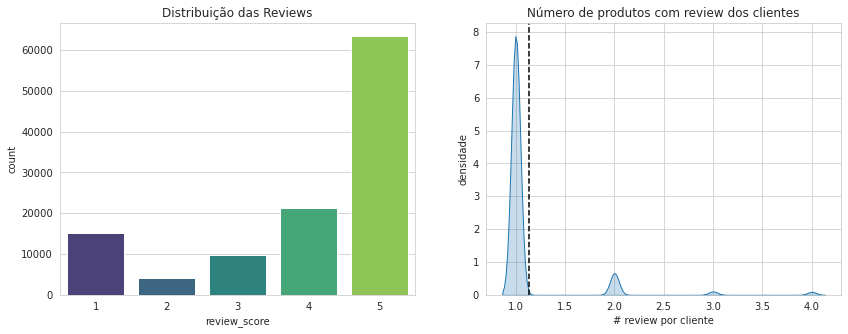

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="review_score", data=df, palette="viridis")
plt.title("Distribuição das Reviews")

plt.subplot(1,2,2)
ax = sns.kdeplot(frequencia_review['n_reviews'], shade=True, legend=False)
plt.axvline(frequencia_review['n_reviews'].mean(), color="k", linestyle="--")
plt.xlabel("# review por cliente")
plt.ylabel("densidade")
plt.title("Número de produtos com review dos clientes")
plt.show()

A nota mais comum no Review é 5, e o número de reviews por cliente é em sua maioria 1, tendo a média geral em torno de 1.17 review por cliente.

## Qual produto é melhor e pior avaliado na média?

In [9]:
media_review = df.groupby('product_id')[['review_score']].mean()

menor_review = media_review['review_score'].idxmin()
df.loc[df['product_id'] == menor_review]

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
99093,6cd217b674e22cf568f6a2cf6060fd07,sao paulo,SP,0bf736fd0fd5169d60de3699fcbcf986,2017-12-21 16:21:47,1,0009406fd7479715e4bef61dd91f2462,229.0,32247878e34bd6e8d7dbf7b31a4ae0b0,1,-23.437321,-46.712576,cama_mesa_banho,1


O produto "0009406fd7479715e4bef61dd91f2462" -  da categoria "Cama Mesa e Banho" é o pior produto de acordo com as notas no Review

In [10]:
maior_review = media_review['review_score'].idxmax()
df.loc[df['product_id'] == maior_review]

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
50624,86c180c33f454b35e1596a99da3dddc4,teutonia,RS,f30149f4a8882a08895b6a242aa0d612,2018-05-20 18:45:21,1,00066f42aeeb9f3007548bb9d3f33c38,101.65,91845d1f2ee1fdb677c769fad86f2109,5,-29.500155,-51.805718,perfumaria,1


O produto "00066f42aeeb9f3007548bb9d3f33c38" - da categoria "Perfumaria" é o melhor produto de acordo com as notas no Review

In [11]:
df[df['product_id'] == maior_review]

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
50624,86c180c33f454b35e1596a99da3dddc4,teutonia,RS,f30149f4a8882a08895b6a242aa0d612,2018-05-20 18:45:21,1,00066f42aeeb9f3007548bb9d3f33c38,101.65,91845d1f2ee1fdb677c769fad86f2109,5,-29.500155,-51.805718,perfumaria,1


Porém o produto citado acima tem apenas uma única revisão. Por isso uma melhor avaliação da popularidade é a Média Bayesiana, onde:
C - representa o tamanho do conjunto de dados
m - representa a classificação média de todos os produtos
N - representa o número total de reviews dos produtos

Mas antes, vamos agrupar os dados dos produtos com a média do review_score.

In [12]:
produto_stats = df.groupby(['product_id', 'product_category_name'])[['review_score']].agg(['count', 'mean'])
produto_stats.columns = produto_stats.columns.droplevel()

In [13]:
produto_stats

,,count,mean
product_id,product_category_name,,
00066f42aeeb9f3007548bb9d3f33c38,perfumaria,1,5.0
00088930e925c41fd95ebfe695fd2655,automotivo,1,4.0
0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,1,1.0
000b8f95fcb9e0096488278317764d19,utilidades_domesticas,2,5.0
000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,1,5.0
...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,cool_stuff,2,4.5
fff81cc3158d2725c0655ab9ba0f712c,beleza_saude,1,4.0
fff9553ac224cec9d15d49f5a263411f,fashion_bolsas_e_acessorios,1,5.0


In [14]:
C = produto_stats['count'].mean()
m = produto_stats['mean'].mean()

def media_bayesiana(reviews):
    media_bayesiana = (C * m + reviews.sum()) / (C + reviews.count())
    
    return media_bayesiana

In [15]:
media_bayesiana_reviews = df.groupby(['product_id'])['review_score'].agg(media_bayesiana).reset_index()
media_bayesiana_reviews.columns = ['product_id', 'media_bayesiana']

In [16]:
media_bayesiana_reviews

,product_id,media_bayesiana
0,00066f42aeeb9f3007548bb9d3f33c38,4.219467
1,00088930e925c41fd95ebfe695fd2655,3.989890
2,0009406fd7479715e4bef61dd91f2462,3.301159
3,000b8f95fcb9e0096488278317764d19,4.365202
4,000d9be29b5207b54e86aa1b1ac54872,4.219467
...,...,...
32395,fff6177642830a9a94a0f2cba5e476d1,4.178490
32396,fff81cc3158d2725c0655ab9ba0f712c,3.989890
32397,fff9553ac224cec9d15d49f5a263411f,4.219467
32398,fffdb2d0ec8d6a61f0a0a0db3f25b441,4.593114


In [17]:
produto_stats = df.groupby(['product_id', 'product_category_name'])[['review_score']].agg(['count', 'mean']).reset_index()

In [18]:
produto_stats = pd.merge(produto_stats, media_bayesiana_reviews, on='product_id')

/home/ariana/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [19]:
produto_stats = produto_stats.drop(['product_id'], axis=1)

In [20]:
produto_stats.sort_values('media_bayesiana', ascending=False).head()

,"(product_id, )","(product_category_name, )","(review_score, count)","(review_score, mean)",media_bayesiana
8319,3e4176d545618ed02f382a3057de32b4,malas_acessorios,24,4.958333,4.839161
7453,37eb69aca8718e843d897aa7b82f462d,ferramentas_jardim,15,5.000000,4.814780
18453,8b6ed41158b194711f83b8da92757544,esporte_lazer,14,5.000000,4.804108
17911,870bcc6c58e03ca658cfdd13db4bbe28,informatica_acessorios,14,5.000000,4.804108
17209,8173ca41cdb176462f9ae79821a48404,esporte_lazer,14,5.000000,4.804108


Usando a média bayesiana, vemos os produtos mais bem avaliados. 

Agora, quais produtos são os mais mal avaliados, de acordo com a média bayesiana?

In [21]:
produto_stats.sort_values('media_bayesiana', ascending=True).head()

,"(product_id, )","(product_category_name, )","(review_score, count)","(review_score, mean)",media_bayesiana
19728,9571759451b1d780ee7c15012ea109d4,automotivo,20,1.0,1.429164
16583,7c68e7297c7df2535c9f0dcd61007f64,moveis_decoracao,10,1.0,1.750494
716,05b515fdc76e888aada3c6d66c201dff,beleza_saude,10,1.0,1.750494
5277,270516a3f41dc035aa87d220228f844c,beleza_saude,10,1.0,1.750494
33207,fb29f48bfea41db52e349454f433340e,informatica_acessorios,10,1.0,1.750494


## Transformar os dados
Estaremos usando uma técnica chamada filtragem colaborativa para gerar recomendações de usuários. Essa técnica é baseada na suposição de "homofilia" - usuários semelhantes gostam de coisas semelhantes. A filtragem colaborativa é um tipo de aprendizagem não supervisionada que faz previsões sobre os interesses de um usuário, aprendendo com os interesses de uma população maior.

A primeira etapa da filtragem colaborativa é transformar nossos dados em uma matriz de item de usuário - também conhecida como matriz de "utilidade". Nesta matriz, as linhas representam os usuários e as colunas representam os itens. A beleza da filtragem colaborativa é que ela não requer nenhuma informação sobre os usuários ou itens para gerar recomendações.

### A função cria_X () produz uma matriz esparsa X com quatro dicionários mapeadores:

cliente_mapper: mapeia o id do cliente para o índice do cliente
produto_mapper: mapeia o id do produto para o índice do produto
cliente_inv_mapper: mapeia o índice do cliente para o id do cliente
produto_inv_mapper: mapeia o índice do produto para o id do produto
Precisamos desses dicionários porque eles mapeiam qual linha e coluna da matriz de utilidade corresponde a qual ID de cliente e ID de produto, respectivamente.

A matriz X (item do cliente) é um scipy.sparse.csr_matrix que armazena os dados esparsamente.

In [22]:
from scipy.sparse import csr_matrix

def cria_X(df):
    N = df['customer_id'].nunique()
    M = df['product_id'].nunique()
    
    cliente_mapper = dict(zip(np.unique(df['customer_id']), list(range(N))))
    produto_mapper = dict(zip(np.unique(df['product_id']), list(range(M))))
    
    cliente_inv_mapper = dict(zip(list(range(N)), np.unique(df['customer_id'])))
    produto_inv_mapper = dict(zip(list(range(M)), np.unique(df['product_id'])))
    
    cliente_index = [cliente_mapper[i] for i in df['customer_id']]
    produto_index = [produto_mapper[i] for i in df['product_id']]
    
    X = csr_matrix((df['review_score'], (produto_index, cliente_index)), shape=(M,N))
    
    return X, cliente_mapper, produto_mapper, cliente_inv_mapper, produto_inv_mapper
    

In [23]:
X, cliente_mapper, produto_mapper, cliente_inv_mapper, produto_inv_mapper = cria_X(df)

## Encontrar produtos semelhantes usando k-Nearest Neighbours

Essa abordagem procura os k vizinhos mais próximos de um determinado produto, identificando k pontos no conjunto de dados que estão mais próximos do produto m. kNN faz uso de métricas de distância.

Embora seja difícil de visualizar, estamos trabalhando em um espaço M-dimensional onde M representa o número de filmes em nossa matriz X.

Para encontrar o número ideal de K
Em geral, cientistas testam valores ímpares para K, pois identificou-se melhores resultados com valores não pares. A melhor maneira de se obter o melhor K é testando diversos valores, podemos tirar a raiz quadrada dos valor total de pontos existentes no dataset ou aplicar técnicas de tunning para identificação do valor que ira performar melhor.

In [24]:
import math
math.sqrt(len(df))

337.07862584269566

A máxima acurácia foi encontrada no K = 38

**Ver no notebook knn_k.ipynb**

### A função encontra_produtos_similares
Argumentos:
product_id - id do produto de interesse
X - matriz de utilidade de item de cliente
k - número de produtos semelhantes para recuperar
métrica - distância métrica para cálculos kNN

Retorna:
lista de k IDs de produtos semelhantes

In [25]:
from sklearn.neighbors import NearestNeighbors

def encontra_produtos_similares(product_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []
    product_ind = produto_mapper[product_id]
    product_vec = X[product_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    
    if isinstance(product_vec, (np.ndarray)):
        product_vec = product_vec.reshape(1, -1)
    
    neighbour = kNN.kneighbors(product_vec, return_distance=show_distance)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(produto_inv_mapper[n])
        
    neighbour_ids.pop(0)
    return neighbour_ids

encontra_produtos_similares() pega um product_id e uma matriz X de item de cliente e produz uma lista de k filmes que são semelhantes ao product_id de interesse.

Vamos ver como funciona em ação. Criaremos primeiro outro mapeador que mapeia product_id para categoria para que nossos resultados sejam mais fáceis de interpretar.

A métrica padrão da função é a distância de cosseno

**Distância de cosseno** - Esta métrica de distância é usada principalmente para calcular a similaridade entre dois vetores. É medido pelo cosseno do ângulo entre dois vetores e determina se dois vetores estão apontando na mesma direção. Geralmente é usado para medir a similaridade de documentos na análise de texto. Quando usada com KNN, essa distância nos dá uma nova perspectiva para um problema de negócios e nos permite encontrar algumas informações ocultas nos dados que não vimos usando as duas matrizes de distância acima.

Ele também é usado em analítica de texto para encontrar semelhanças entre dois documentos pelo número de vezes que um determinado conjunto de palavras aparece nele.

In [26]:
nome_produtos = dict(zip(df['product_id'], df['product_category_name']))

produto_id = '3e4176d545618ed02f382a3057de32b4'

similar_ids = encontra_produtos_similares(produto_id, X, k=38)
nome_produto = nome_produtos[produto_id]

print("Porque você comprou o Produto " + produto_id + " da Categoria " + nome_produto)
for i in similar_ids:
    print("Produto: " + i + " da Categoria: " + nome_produtos[i])

Porque você comprou o Produto 3e4176d545618ed02f382a3057de32b4 da Categoria malas_acessorios
Produto: ab8a616a62326859211452cc82885197 da Categoria: bebidas
Produto: ab687729e8507381d0b4aa32bef2d723 da Categoria: moveis_decoracao
Produto: ab6894479165254fa26f0fbb31c53ce4 da Categoria: cama_mesa_banho
Produto: ab6ac334be05ff833a2e3973927dd83c da Categoria: beleza_saude
Produto: ab6daa82c0ec6a0a6898c06151cc3c64 da Categoria: papelaria
Produto: ab6edd00a29d1e29948284a492497854 da Categoria: eletrodomesticos
Produto: ab71466511b5e49de73454353d49a2ba da Categoria: bebes
Produto: ab7b628864c6935e8c1f1e993bbc4c81 da Categoria: automotivo
Produto: ab7be0a001c3104b4931ce39ed70857d da Categoria: informatica_acessorios
Produto: ab89689c2d13440b8152183ddee2ed81 da Categoria: esporte_lazer
Produto: ab459aea1242203ebcbd7b18c2c6e6b0 da Categoria: market_place
Produto: abb1b334edaeb7f4de5f7724b7fd94cf da Categoria: moveis_decoracao
Produto: abb9de7600a7ae9a81564692f77fc9f3 da Categoria: moveis_decorac